<a href="https://colab.research.google.com/github/vivekvj18/ML-PROJECT-2/blob/main/ML_2(Neural_89_19).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# CELL 1 — Setup & imports
import os, time, random, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Reproducibility (best-effort)
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# TensorFlow
import tensorflow as tf
tf.random.set_seed(SEED)

print("TF version:", tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPUs:", gpus)


TF version: 2.19.0
GPUs: []


In [8]:
# CELL 2 — Load dataset (upload to /content or mount Drive)
DATA_PATH = "covtype.csv"   # change if needed (or mount Drive)

print("Reading:", DATA_PATH)
df = pd.read_csv(DATA_PATH)
print("Loaded shape:", df.shape)
df.head()


Reading: covtype.csv
Loaded shape: (581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [9]:
# CELL 3 — Columns, cleaning, feature matrix and zero-based labels
# Correct continuous columns
continuous_cols = [
    'Elevation','Aspect','Slope',
    'Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
]

# Identify target and features
target_col = 'Cover_Type' if 'Cover_Type' in df.columns else df.columns[-1]
feature_cols = [c for c in df.columns if c != target_col]
binary_cols = [c for c in feature_cols if c not in continuous_cols]

print("Target:", target_col)
print("Features total:", len(feature_cols), "| continuous:", len(continuous_cols), "| binary:", len(binary_cols))

# Basic cleaning
df = df.dropna(subset=[target_col])
df = df.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)
df[target_col] = df[target_col].astype(int)

# Build feature matrix X_all: scaled continuous + binary cols appended
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_cont_scaled = scaler.fit_transform(df[continuous_cols])
X_all = np.hstack([X_cont_scaled, df[binary_cols].values]).astype(np.float32)

# Convert labels 1..7 -> 0..6 for Keras sparse loss
y_orig = df[target_col].values.astype(int)        # keep original for reference
y = y_orig - 1                                    # zero-based

print("X_all shape:", X_all.shape, "y shape:", y.shape)
print("Original label range:", y_orig.min(), "to", y_orig.max())
print("Zero-based label range:", y.min(), "to", y.max())


Target: Cover_Type
Features total: 54 | continuous: 10 | binary: 44
X_all shape: (581012, 54) y shape: (581012,)
Original label range: 1 to 7
Zero-based label range: 0 to 6


In [10]:
# CELL 4 — Stratified train/test split and compute class weights
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.20, stratify=y, random_state=SEED
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

classes = np.unique(y_train)
class_weights_arr = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, class_weights_arr)}
print("Class weight dict (zero-based):", class_weight_dict)


Train shape: (464809, 54) Test shape: (116203, 54)
Class weight dict (zero-based): {0: 0.39181272253992233, 1: 0.29298131712974634, 2: 2.3214797648598298, 3: 30.209866112049916, 4: 8.743914368486399, 5: 4.779133850171708, 6: 4.046884794873581}


In [11]:
# CELL 5 — Build MLP model function
from tensorflow.keras import layers, models, optimizers, regularizers

input_dim = X_train.shape[1]
n_classes = len(classes)

def build_mlp(input_dim, n_classes, lr=1e-3, l2_reg=1e-4, dropout_rate=0.3):
    inp = layers.Input(shape=(input_dim,))
    x = layers.BatchNormalization()(inp)

    x = layers.Dense(512, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(256, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    out = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    return model

model = build_mlp(input_dim, n_classes, lr=1e-3, l2_reg=1e-4, dropout_rate=0.3)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 54)             │           216 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │        28,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,087 (769.87 KB)

 Trainable params: 195,187 (762.45 KB)

 Non-trainable params: 1,900 (7.42 KB)

In [12]:
# CELL 6 — Callbacks and fit (adjust BATCH_SIZE if OOM)
from tensorflow.keras import callbacks

BATCH_SIZE = 1024   # change to 512 or 256 if you hit OOM
EPOCHS = 100

es = callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=8,
                             mode='max', restore_best_weights=True, verbose=1)
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4,
                                  verbose=1, min_lr=1e-6)
mc = callbacks.ModelCheckpoint("mlp_best_full.h5", monitor='val_sparse_categorical_accuracy',
                               save_best_only=True, mode='max', verbose=1)

t0 = time.time()
history = model.fit(
    X_train, y_train,
    validation_split=0.10,    # 10% of train used as val
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[es, rlr, mc],
    verbose=2
)
t1 = time.time()
print("Training finished. Time (s):", round(t1 - t0, 1))


Epoch 1/100

Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.63413, saving model to mlp_best_full.h5


409/409 - 25s - 62ms/step - loss: 1.0039 - sparse_categorical_accuracy: 0.5391 - val_loss: 0.8998 - val_sparse_categorical_accuracy: 0.6341 - learning_rate: 1.0000e-03
Epoch 2/100

Epoch 2: val_sparse_categorical_accuracy improved from 0.63413 to 0.65868, saving model to mlp_best_full.h5


409/409 - 40s - 97ms/step - loss: 0.7288 - sparse_categorical_accuracy: 0.6211 - val_loss: 0.8445 - val_sparse_categorical_accuracy: 0.6587 - learning_rate: 1.0000e-03
Epoch 3/100

Epoch 3: val_sparse_categorical_accuracy improved from 0.65868 to 0.68122, saving model to mlp_best_full.h5


409/409 - 22s - 53ms/step - loss: 0.6572 - sparse_categorical_accuracy: 0.6507 - val_loss: 0.7916 - val_sparse_categorical_accuracy: 0.6812 - learning_rate: 1.0000e-03
Epoch 4/100

Epoch 4: val_sparse_categorical_accuracy improved from 0.68122 to 0.69605, saving model to mlp_best_full.h5


409/409 - 40s - 98ms/step - loss: 0.6050 - sparse_categorical_accuracy: 0.6741 - val_loss: 0.7541 - val_sparse_categorical_accuracy: 0.6960 - learning_rate: 1.0000e-03
Epoch 5/100

Epoch 5: val_sparse_categorical_accuracy improved from 0.69605 to 0.71679, saving model to mlp_best_full.h5


409/409 - 41s - 99ms/step - loss: 0.5663 - sparse_categorical_accuracy: 0.6912 - val_loss: 0.7079 - val_sparse_categorical_accuracy: 0.7168 - learning_rate: 1.0000e-03
Epoch 6/100

Epoch 6: val_sparse_categorical_accuracy improved from 0.71679 to 0.72436, saving model to mlp_best_full.h5


409/409 - 21s - 51ms/step - loss: 0.5383 - sparse_categorical_accuracy: 0.7055 - val_loss: 0.6938 - val_sparse_categorical_accuracy: 0.7244 - learning_rate: 1.0000e-03
Epoch 7/100

Epoch 7: val_sparse_categorical_accuracy improved from 0.72436 to 0.73561, saving model to mlp_best_full.h5


409/409 - 22s - 53ms/step - loss: 0.5105 - sparse_categorical_accuracy: 0.7174 - val_loss: 0.6707 - val_sparse_categorical_accuracy: 0.7356 - learning_rate: 1.0000e-03
Epoch 8/100

Epoch 8: val_sparse_categorical_accuracy improved from 0.73561 to 0.74547, saving model to mlp_best_full.h5


409/409 - 20s - 49ms/step - loss: 0.4919 - sparse_categorical_accuracy: 0.7283 - val_loss: 0.6653 - val_sparse_categorical_accuracy: 0.7455 - learning_rate: 1.0000e-03
Epoch 9/100

Epoch 9: val_sparse_categorical_accuracy improved from 0.74547 to 0.75102, saving model to mlp_best_full.h5


409/409 - 22s - 53ms/step - loss: 0.4789 - sparse_categorical_accuracy: 0.7370 - val_loss: 0.6408 - val_sparse_categorical_accuracy: 0.7510 - learning_rate: 1.0000e-03
Epoch 10/100

Epoch 10: val_sparse_categorical_accuracy improved from 0.75102 to 0.76253, saving model to mlp_best_full.h5


409/409 - 40s - 97ms/step - loss: 0.4574 - sparse_categorical_accuracy: 0.7465 - val_loss: 0.6197 - val_sparse_categorical_accuracy: 0.7625 - learning_rate: 1.0000e-03
Epoch 11/100

Epoch 11: val_sparse_categorical_accuracy improved from 0.76253 to 0.77705, saving model to mlp_best_full.h5


409/409 - 21s - 52ms/step - loss: 0.4477 - sparse_categorical_accuracy: 0.7525 - val_loss: 0.5940 - val_sparse_categorical_accuracy: 0.7770 - learning_rate: 1.0000e-03
Epoch 12/100

Epoch 12: val_sparse_categorical_accuracy improved from 0.77705 to 0.78484, saving model to mlp_best_full.h5


409/409 - 40s - 98ms/step - loss: 0.4375 - sparse_categorical_accuracy: 0.7595 - val_loss: 0.5740 - val_sparse_categorical_accuracy: 0.7848 - learning_rate: 1.0000e-03
Epoch 13/100

Epoch 13: val_sparse_categorical_accuracy did not improve from 0.78484
409/409 - 21s - 52ms/step - loss: 0.4276 - sparse_categorical_accuracy: 0.7668 - val_loss: 0.5934 - val_sparse_categorical_accuracy: 0.7802 - learning_rate: 1.0000e-03
Epoch 14/100

Epoch 14: val_sparse_categorical_accuracy improved from 0.78484 to 0.79002, saving model to mlp_best_full.h5


409/409 - 22s - 53ms/step - loss: 0.4210 - sparse_categorical_accuracy: 0.7701 - val_loss: 0.5641 - val_sparse_categorical_accuracy: 0.7900 - learning_rate: 1.0000e-03
Epoch 15/100

Epoch 15: val_sparse_categorical_accuracy improved from 0.79002 to 0.79465, saving model to mlp_best_full.h5


409/409 - 20s - 50ms/step - loss: 0.4120 - sparse_categorical_accuracy: 0.7739 - val_loss: 0.5629 - val_sparse_categorical_accuracy: 0.7946 - learning_rate: 1.0000e-03
Epoch 16/100

Epoch 16: val_sparse_categorical_accuracy improved from 0.79465 to 0.80340, saving model to mlp_best_full.h5


409/409 - 21s - 52ms/step - loss: 0.4105 - sparse_categorical_accuracy: 0.7775 - val_loss: 0.5519 - val_sparse_categorical_accuracy: 0.8034 - learning_rate: 1.0000e-03
Epoch 17/100

Epoch 17: val_sparse_categorical_accuracy improved from 0.80340 to 0.81119, saving model to mlp_best_full.h5


409/409 - 21s - 52ms/step - loss: 0.4001 - sparse_categorical_accuracy: 0.7826 - val_loss: 0.5286 - val_sparse_categorical_accuracy: 0.8112 - learning_rate: 1.0000e-03
Epoch 18/100

Epoch 18: val_sparse_categorical_accuracy improved from 0.81119 to 0.81668, saving model to mlp_best_full.h5


409/409 - 41s - 101ms/step - loss: 0.3979 - sparse_categorical_accuracy: 0.7857 - val_loss: 0.5106 - val_sparse_categorical_accuracy: 0.8167 - learning_rate: 1.0000e-03
Epoch 19/100

Epoch 19: val_sparse_categorical_accuracy did not improve from 0.81668
409/409 - 21s - 52ms/step - loss: 0.3964 - sparse_categorical_accuracy: 0.7874 - val_loss: 0.5348 - val_sparse_categorical_accuracy: 0.8059 - learning_rate: 1.0000e-03
Epoch 20/100

Epoch 20: val_sparse_categorical_accuracy did not improve from 0.81668
409/409 - 42s - 102ms/step - loss: 0.3876 - sparse_categorical_accuracy: 0.7912 - val_loss: 0.5461 - val_sparse_categorical_accuracy: 0.8054 - learning_rate: 1.0000e-03
Epoch 21/100

Epoch 21: val_sparse_categorical_accuracy did not improve from 0.81668
409/409 - 40s - 97ms/step - loss: 0.3831 - sparse_categorical_accuracy: 0.7930 - val_loss: 0.5267 - val_sparse_categorical_accuracy: 0.8127 - learning_rate: 1.0000e-03
Epoch 22/100

Epoch 22: val_sparse_categorical_accuracy improved from 0

409/409 - 41s - 101ms/step - loss: 0.3840 - sparse_categorical_accuracy: 0.7944 - val_loss: 0.5087 - val_sparse_categorical_accuracy: 0.8187 - learning_rate: 1.0000e-03
Epoch 23/100

Epoch 23: val_sparse_categorical_accuracy did not improve from 0.81872
409/409 - 41s - 100ms/step - loss: 0.3815 - sparse_categorical_accuracy: 0.7960 - val_loss: 0.5117 - val_sparse_categorical_accuracy: 0.8176 - learning_rate: 1.0000e-03
Epoch 24/100

Epoch 24: val_sparse_categorical_accuracy improved from 0.81872 to 0.82077, saving model to mlp_best_full.h5


409/409 - 40s - 98ms/step - loss: 0.3769 - sparse_categorical_accuracy: 0.7989 - val_loss: 0.5077 - val_sparse_categorical_accuracy: 0.8208 - learning_rate: 1.0000e-03
Epoch 25/100

Epoch 25: val_sparse_categorical_accuracy did not improve from 0.82077
409/409 - 22s - 53ms/step - loss: 0.3789 - sparse_categorical_accuracy: 0.7986 - val_loss: 0.5062 - val_sparse_categorical_accuracy: 0.8197 - learning_rate: 1.0000e-03
Epoch 26/100

Epoch 26: val_sparse_categorical_accuracy did not improve from 0.82077
409/409 - 21s - 52ms/step - loss: 0.3719 - sparse_categorical_accuracy: 0.8006 - val_loss: 0.5103 - val_sparse_categorical_accuracy: 0.8203 - learning_rate: 1.0000e-03
Epoch 27/100

Epoch 27: val_sparse_categorical_accuracy improved from 0.82077 to 0.82457, saving model to mlp_best_full.h5


409/409 - 21s - 51ms/step - loss: 0.3694 - sparse_categorical_accuracy: 0.8034 - val_loss: 0.4949 - val_sparse_categorical_accuracy: 0.8246 - learning_rate: 1.0000e-03
Epoch 28/100

Epoch 28: val_sparse_categorical_accuracy improved from 0.82457 to 0.82597, saving model to mlp_best_full.h5


409/409 - 22s - 53ms/step - loss: 0.3696 - sparse_categorical_accuracy: 0.8039 - val_loss: 0.4960 - val_sparse_categorical_accuracy: 0.8260 - learning_rate: 1.0000e-03
Epoch 29/100

Epoch 29: val_sparse_categorical_accuracy improved from 0.82597 to 0.82933, saving model to mlp_best_full.h5


409/409 - 41s - 99ms/step - loss: 0.3684 - sparse_categorical_accuracy: 0.8050 - val_loss: 0.4895 - val_sparse_categorical_accuracy: 0.8293 - learning_rate: 1.0000e-03
Epoch 30/100

Epoch 30: val_sparse_categorical_accuracy did not improve from 0.82933
409/409 - 22s - 53ms/step - loss: 0.3625 - sparse_categorical_accuracy: 0.8071 - val_loss: 0.5258 - val_sparse_categorical_accuracy: 0.8181 - learning_rate: 1.0000e-03
Epoch 31/100

Epoch 31: val_sparse_categorical_accuracy did not improve from 0.82933
409/409 - 40s - 99ms/step - loss: 0.3615 - sparse_categorical_accuracy: 0.8081 - val_loss: 0.4984 - val_sparse_categorical_accuracy: 0.8269 - learning_rate: 1.0000e-03
Epoch 32/100

Epoch 32: val_sparse_categorical_accuracy did not improve from 0.82933
409/409 - 22s - 53ms/step - loss: 0.3621 - sparse_categorical_accuracy: 0.8084 - val_loss: 0.4943 - val_sparse_categorical_accuracy: 0.8264 - learning_rate: 1.0000e-03
Epoch 33/100

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.000

409/409 - 21s - 51ms/step - loss: 0.3629 - sparse_categorical_accuracy: 0.8089 - val_loss: 0.4920 - val_sparse_categorical_accuracy: 0.8295 - learning_rate: 1.0000e-03
Epoch 34/100

Epoch 34: val_sparse_categorical_accuracy improved from 0.82948 to 0.84391, saving model to mlp_best_full.h5


409/409 - 21s - 52ms/step - loss: 0.3391 - sparse_categorical_accuracy: 0.8193 - val_loss: 0.4545 - val_sparse_categorical_accuracy: 0.8439 - learning_rate: 5.0000e-04
Epoch 35/100

Epoch 35: val_sparse_categorical_accuracy improved from 0.84391 to 0.85405, saving model to mlp_best_full.h5


409/409 - 21s - 52ms/step - loss: 0.3285 - sparse_categorical_accuracy: 0.8240 - val_loss: 0.4282 - val_sparse_categorical_accuracy: 0.8540 - learning_rate: 5.0000e-04
Epoch 36/100

Epoch 36: val_sparse_categorical_accuracy did not improve from 0.85405
409/409 - 20s - 49ms/step - loss: 0.3205 - sparse_categorical_accuracy: 0.8264 - val_loss: 0.4266 - val_sparse_categorical_accuracy: 0.8538 - learning_rate: 5.0000e-04
Epoch 37/100

Epoch 37: val_sparse_categorical_accuracy improved from 0.85405 to 0.85682, saving model to mlp_best_full.h5


409/409 - 22s - 53ms/step - loss: 0.3183 - sparse_categorical_accuracy: 0.8275 - val_loss: 0.4219 - val_sparse_categorical_accuracy: 0.8568 - learning_rate: 5.0000e-04
Epoch 38/100

Epoch 38: val_sparse_categorical_accuracy did not improve from 0.85682
409/409 - 40s - 97ms/step - loss: 0.3194 - sparse_categorical_accuracy: 0.8276 - val_loss: 0.4261 - val_sparse_categorical_accuracy: 0.8540 - learning_rate: 5.0000e-04
Epoch 39/100

Epoch 39: val_sparse_categorical_accuracy did not improve from 0.85682
409/409 - 22s - 53ms/step - loss: 0.3153 - sparse_categorical_accuracy: 0.8278 - val_loss: 0.4188 - val_sparse_categorical_accuracy: 0.8551 - learning_rate: 5.0000e-04
Epoch 40/100

Epoch 40: val_sparse_categorical_accuracy did not improve from 0.85682
409/409 - 21s - 52ms/step - loss: 0.3109 - sparse_categorical_accuracy: 0.8304 - val_loss: 0.4267 - val_sparse_categorical_accuracy: 0.8548 - learning_rate: 5.0000e-04
Epoch 41/100

Epoch 41: val_sparse_categorical_accuracy improved from 0.8

409/409 - 20s - 50ms/step - loss: 0.3098 - sparse_categorical_accuracy: 0.8304 - val_loss: 0.4093 - val_sparse_categorical_accuracy: 0.8595 - learning_rate: 5.0000e-04
Epoch 42/100

Epoch 42: val_sparse_categorical_accuracy improved from 0.85949 to 0.86102, saving model to mlp_best_full.h5


409/409 - 21s - 52ms/step - loss: 0.3043 - sparse_categorical_accuracy: 0.8323 - val_loss: 0.4091 - val_sparse_categorical_accuracy: 0.8610 - learning_rate: 5.0000e-04
Epoch 43/100

Epoch 43: val_sparse_categorical_accuracy improved from 0.86102 to 0.86197, saving model to mlp_best_full.h5


409/409 - 21s - 51ms/step - loss: 0.3047 - sparse_categorical_accuracy: 0.8321 - val_loss: 0.4074 - val_sparse_categorical_accuracy: 0.8620 - learning_rate: 5.0000e-04
Epoch 44/100

Epoch 44: val_sparse_categorical_accuracy did not improve from 0.86197
409/409 - 21s - 50ms/step - loss: 0.3033 - sparse_categorical_accuracy: 0.8327 - val_loss: 0.4194 - val_sparse_categorical_accuracy: 0.8556 - learning_rate: 5.0000e-04
Epoch 45/100

Epoch 45: val_sparse_categorical_accuracy did not improve from 0.86197
409/409 - 22s - 53ms/step - loss: 0.3017 - sparse_categorical_accuracy: 0.8328 - val_loss: 0.4065 - val_sparse_categorical_accuracy: 0.8606 - learning_rate: 5.0000e-04
Epoch 46/100

Epoch 46: val_sparse_categorical_accuracy did not improve from 0.86197
409/409 - 40s - 98ms/step - loss: 0.3035 - sparse_categorical_accuracy: 0.8323 - val_loss: 0.4083 - val_sparse_categorical_accuracy: 0.8590 - learning_rate: 5.0000e-04
Epoch 47/100

Epoch 47: val_sparse_categorical_accuracy improved from 0.8

409/409 - 42s - 102ms/step - loss: 0.3015 - sparse_categorical_accuracy: 0.8329 - val_loss: 0.3993 - val_sparse_categorical_accuracy: 0.8633 - learning_rate: 5.0000e-04
Epoch 48/100

Epoch 48: val_sparse_categorical_accuracy did not improve from 0.86332
409/409 - 41s - 101ms/step - loss: 0.2957 - sparse_categorical_accuracy: 0.8342 - val_loss: 0.3965 - val_sparse_categorical_accuracy: 0.8622 - learning_rate: 5.0000e-04
Epoch 49/100

Epoch 49: val_sparse_categorical_accuracy improved from 0.86332 to 0.86620, saving model to mlp_best_full.h5


409/409 - 40s - 98ms/step - loss: 0.2962 - sparse_categorical_accuracy: 0.8353 - val_loss: 0.3912 - val_sparse_categorical_accuracy: 0.8662 - learning_rate: 5.0000e-04
Epoch 50/100

Epoch 50: val_sparse_categorical_accuracy did not improve from 0.86620
409/409 - 22s - 53ms/step - loss: 0.2984 - sparse_categorical_accuracy: 0.8348 - val_loss: 0.3951 - val_sparse_categorical_accuracy: 0.8649 - learning_rate: 5.0000e-04
Epoch 51/100

Epoch 51: val_sparse_categorical_accuracy did not improve from 0.86620
409/409 - 40s - 98ms/step - loss: 0.2964 - sparse_categorical_accuracy: 0.8356 - val_loss: 0.3967 - val_sparse_categorical_accuracy: 0.8628 - learning_rate: 5.0000e-04
Epoch 52/100

Epoch 52: val_sparse_categorical_accuracy did not improve from 0.86620
409/409 - 22s - 53ms/step - loss: 0.2930 - sparse_categorical_accuracy: 0.8368 - val_loss: 0.3967 - val_sparse_categorical_accuracy: 0.8634 - learning_rate: 5.0000e-04
Epoch 53/100

Epoch 53: ReduceLROnPlateau reducing learning rate to 0.000

409/409 - 41s - 99ms/step - loss: 0.2816 - sparse_categorical_accuracy: 0.8410 - val_loss: 0.3756 - val_sparse_categorical_accuracy: 0.8721 - learning_rate: 2.5000e-04
Epoch 55/100

Epoch 55: val_sparse_categorical_accuracy improved from 0.87206 to 0.87451, saving model to mlp_best_full.h5


409/409 - 41s - 101ms/step - loss: 0.2749 - sparse_categorical_accuracy: 0.8446 - val_loss: 0.3737 - val_sparse_categorical_accuracy: 0.8745 - learning_rate: 2.5000e-04
Epoch 56/100

Epoch 56: val_sparse_categorical_accuracy improved from 0.87451 to 0.87539, saving model to mlp_best_full.h5


409/409 - 40s - 98ms/step - loss: 0.2725 - sparse_categorical_accuracy: 0.8460 - val_loss: 0.3658 - val_sparse_categorical_accuracy: 0.8754 - learning_rate: 2.5000e-04
Epoch 57/100

Epoch 57: val_sparse_categorical_accuracy did not improve from 0.87539
409/409 - 22s - 53ms/step - loss: 0.2702 - sparse_categorical_accuracy: 0.8466 - val_loss: 0.3666 - val_sparse_categorical_accuracy: 0.8750 - learning_rate: 2.5000e-04
Epoch 58/100

Epoch 58: val_sparse_categorical_accuracy improved from 0.87539 to 0.87655, saving model to mlp_best_full.h5


409/409 - 21s - 52ms/step - loss: 0.2701 - sparse_categorical_accuracy: 0.8472 - val_loss: 0.3636 - val_sparse_categorical_accuracy: 0.8766 - learning_rate: 2.5000e-04
Epoch 59/100

Epoch 59: val_sparse_categorical_accuracy did not improve from 0.87655
409/409 - 41s - 100ms/step - loss: 0.2652 - sparse_categorical_accuracy: 0.8486 - val_loss: 0.3648 - val_sparse_categorical_accuracy: 0.8759 - learning_rate: 2.5000e-04
Epoch 60/100

Epoch 60: val_sparse_categorical_accuracy improved from 0.87655 to 0.87746, saving model to mlp_best_full.h5


409/409 - 40s - 98ms/step - loss: 0.2625 - sparse_categorical_accuracy: 0.8498 - val_loss: 0.3606 - val_sparse_categorical_accuracy: 0.8775 - learning_rate: 2.5000e-04
Epoch 61/100

Epoch 61: val_sparse_categorical_accuracy improved from 0.87746 to 0.87855, saving model to mlp_best_full.h5


409/409 - 21s - 52ms/step - loss: 0.2622 - sparse_categorical_accuracy: 0.8498 - val_loss: 0.3580 - val_sparse_categorical_accuracy: 0.8786 - learning_rate: 2.5000e-04
Epoch 62/100

Epoch 62: val_sparse_categorical_accuracy did not improve from 0.87855
409/409 - 20s - 49ms/step - loss: 0.2588 - sparse_categorical_accuracy: 0.8492 - val_loss: 0.3635 - val_sparse_categorical_accuracy: 0.8760 - learning_rate: 2.5000e-04
Epoch 63/100

Epoch 63: val_sparse_categorical_accuracy did not improve from 0.87855
409/409 - 22s - 53ms/step - loss: 0.2626 - sparse_categorical_accuracy: 0.8495 - val_loss: 0.3600 - val_sparse_categorical_accuracy: 0.8777 - learning_rate: 2.5000e-04
Epoch 64/100

Epoch 64: val_sparse_categorical_accuracy improved from 0.87855 to 0.87948, saving model to mlp_best_full.h5


409/409 - 21s - 52ms/step - loss: 0.2625 - sparse_categorical_accuracy: 0.8497 - val_loss: 0.3572 - val_sparse_categorical_accuracy: 0.8795 - learning_rate: 2.5000e-04
Epoch 65/100

Epoch 65: val_sparse_categorical_accuracy did not improve from 0.87948
409/409 - 21s - 50ms/step - loss: 0.2610 - sparse_categorical_accuracy: 0.8502 - val_loss: 0.3548 - val_sparse_categorical_accuracy: 0.8784 - learning_rate: 2.5000e-04
Epoch 66/100

Epoch 66: val_sparse_categorical_accuracy did not improve from 0.87948
409/409 - 21s - 52ms/step - loss: 0.2573 - sparse_categorical_accuracy: 0.8512 - val_loss: 0.3558 - val_sparse_categorical_accuracy: 0.8793 - learning_rate: 2.5000e-04
Epoch 67/100

Epoch 67: val_sparse_categorical_accuracy improved from 0.87948 to 0.88057, saving model to mlp_best_full.h5


409/409 - 21s - 52ms/step - loss: 0.2563 - sparse_categorical_accuracy: 0.8517 - val_loss: 0.3527 - val_sparse_categorical_accuracy: 0.8806 - learning_rate: 2.5000e-04
Epoch 68/100

Epoch 68: val_sparse_categorical_accuracy improved from 0.88057 to 0.88270, saving model to mlp_best_full.h5


409/409 - 20s - 50ms/step - loss: 0.2557 - sparse_categorical_accuracy: 0.8515 - val_loss: 0.3485 - val_sparse_categorical_accuracy: 0.8827 - learning_rate: 2.5000e-04
Epoch 69/100

Epoch 69: val_sparse_categorical_accuracy did not improve from 0.88270
409/409 - 22s - 53ms/step - loss: 0.2540 - sparse_categorical_accuracy: 0.8520 - val_loss: 0.3455 - val_sparse_categorical_accuracy: 0.8816 - learning_rate: 2.5000e-04
Epoch 70/100

Epoch 70: val_sparse_categorical_accuracy did not improve from 0.88270
409/409 - 21s - 52ms/step - loss: 0.2561 - sparse_categorical_accuracy: 0.8517 - val_loss: 0.3496 - val_sparse_categorical_accuracy: 0.8815 - learning_rate: 2.5000e-04
Epoch 71/100

Epoch 71: val_sparse_categorical_accuracy did not improve from 0.88270
409/409 - 20s - 49ms/step - loss: 0.2532 - sparse_categorical_accuracy: 0.8522 - val_loss: 0.3462 - val_sparse_categorical_accuracy: 0.8819 - learning_rate: 2.5000e-04
Epoch 72/100

Epoch 72: val_sparse_categorical_accuracy did not improve f

409/409 - 21s - 51ms/step - loss: 0.2511 - sparse_categorical_accuracy: 0.8523 - val_loss: 0.3402 - val_sparse_categorical_accuracy: 0.8843 - learning_rate: 2.5000e-04
Epoch 74/100

Epoch 74: val_sparse_categorical_accuracy did not improve from 0.88428
409/409 - 20s - 50ms/step - loss: 0.2519 - sparse_categorical_accuracy: 0.8531 - val_loss: 0.3466 - val_sparse_categorical_accuracy: 0.8834 - learning_rate: 2.5000e-04
Epoch 75/100

Epoch 75: val_sparse_categorical_accuracy did not improve from 0.88428
409/409 - 21s - 52ms/step - loss: 0.2528 - sparse_categorical_accuracy: 0.8534 - val_loss: 0.3409 - val_sparse_categorical_accuracy: 0.8838 - learning_rate: 2.5000e-04
Epoch 76/100

Epoch 76: val_sparse_categorical_accuracy did not improve from 0.88428
409/409 - 20s - 49ms/step - loss: 0.2501 - sparse_categorical_accuracy: 0.8534 - val_loss: 0.3426 - val_sparse_categorical_accuracy: 0.8839 - learning_rate: 2.5000e-04
Epoch 77/100

Epoch 77: ReduceLROnPlateau reducing learning rate to 0.000

409/409 - 21s - 51ms/step - loss: 0.2432 - sparse_categorical_accuracy: 0.8559 - val_loss: 0.3359 - val_sparse_categorical_accuracy: 0.8861 - learning_rate: 1.2500e-04
Epoch 79/100

Epoch 79: val_sparse_categorical_accuracy improved from 0.88608 to 0.88647, saving model to mlp_best_full.h5


409/409 - 41s - 101ms/step - loss: 0.2395 - sparse_categorical_accuracy: 0.8576 - val_loss: 0.3351 - val_sparse_categorical_accuracy: 0.8865 - learning_rate: 1.2500e-04
Epoch 80/100

Epoch 80: val_sparse_categorical_accuracy improved from 0.88647 to 0.88789, saving model to mlp_best_full.h5


409/409 - 40s - 99ms/step - loss: 0.2398 - sparse_categorical_accuracy: 0.8587 - val_loss: 0.3283 - val_sparse_categorical_accuracy: 0.8879 - learning_rate: 1.2500e-04
Epoch 81/100

Epoch 81: val_sparse_categorical_accuracy did not improve from 0.88789
409/409 - 22s - 53ms/step - loss: 0.2365 - sparse_categorical_accuracy: 0.8592 - val_loss: 0.3340 - val_sparse_categorical_accuracy: 0.8867 - learning_rate: 1.2500e-04
Epoch 82/100

Epoch 82: val_sparse_categorical_accuracy improved from 0.88789 to 0.88828, saving model to mlp_best_full.h5


409/409 - 21s - 51ms/step - loss: 0.2360 - sparse_categorical_accuracy: 0.8598 - val_loss: 0.3310 - val_sparse_categorical_accuracy: 0.8883 - learning_rate: 1.2500e-04
Epoch 83/100

Epoch 83: val_sparse_categorical_accuracy improved from 0.88828 to 0.88858, saving model to mlp_best_full.h5


409/409 - 20s - 50ms/step - loss: 0.2366 - sparse_categorical_accuracy: 0.8602 - val_loss: 0.3275 - val_sparse_categorical_accuracy: 0.8886 - learning_rate: 1.2500e-04
Epoch 84/100

Epoch 84: val_sparse_categorical_accuracy improved from 0.88858 to 0.88888, saving model to mlp_best_full.h5


409/409 - 22s - 53ms/step - loss: 0.2341 - sparse_categorical_accuracy: 0.8598 - val_loss: 0.3270 - val_sparse_categorical_accuracy: 0.8889 - learning_rate: 1.2500e-04
Epoch 85/100

Epoch 85: val_sparse_categorical_accuracy improved from 0.88888 to 0.88976, saving model to mlp_best_full.h5


409/409 - 21s - 52ms/step - loss: 0.2341 - sparse_categorical_accuracy: 0.8613 - val_loss: 0.3228 - val_sparse_categorical_accuracy: 0.8898 - learning_rate: 1.2500e-04
Epoch 86/100

Epoch 86: val_sparse_categorical_accuracy improved from 0.88976 to 0.89011, saving model to mlp_best_full.h5


409/409 - 21s - 51ms/step - loss: 0.2333 - sparse_categorical_accuracy: 0.8615 - val_loss: 0.3260 - val_sparse_categorical_accuracy: 0.8901 - learning_rate: 1.2500e-04
Epoch 87/100

Epoch 87: val_sparse_categorical_accuracy did not improve from 0.89011
409/409 - 21s - 52ms/step - loss: 0.2330 - sparse_categorical_accuracy: 0.8614 - val_loss: 0.3263 - val_sparse_categorical_accuracy: 0.8887 - learning_rate: 1.2500e-04
Epoch 88/100

Epoch 88: val_sparse_categorical_accuracy improved from 0.89011 to 0.89122, saving model to mlp_best_full.h5


409/409 - 20s - 50ms/step - loss: 0.2330 - sparse_categorical_accuracy: 0.8609 - val_loss: 0.3210 - val_sparse_categorical_accuracy: 0.8912 - learning_rate: 1.2500e-04
Epoch 89/100

Epoch 89: val_sparse_categorical_accuracy did not improve from 0.89122
409/409 - 21s - 52ms/step - loss: 0.2314 - sparse_categorical_accuracy: 0.8612 - val_loss: 0.3240 - val_sparse_categorical_accuracy: 0.8902 - learning_rate: 1.2500e-04
Epoch 90/100

Epoch 90: val_sparse_categorical_accuracy improved from 0.89122 to 0.89183, saving model to mlp_best_full.h5


409/409 - 21s - 52ms/step - loss: 0.2288 - sparse_categorical_accuracy: 0.8617 - val_loss: 0.3203 - val_sparse_categorical_accuracy: 0.8918 - learning_rate: 1.2500e-04
Epoch 91/100

Epoch 91: val_sparse_categorical_accuracy did not improve from 0.89183
409/409 - 20s - 49ms/step - loss: 0.2307 - sparse_categorical_accuracy: 0.8627 - val_loss: 0.3225 - val_sparse_categorical_accuracy: 0.8903 - learning_rate: 1.2500e-04
Epoch 92/100

Epoch 92: val_sparse_categorical_accuracy improved from 0.89183 to 0.89213, saving model to mlp_best_full.h5


409/409 - 21s - 52ms/step - loss: 0.2292 - sparse_categorical_accuracy: 0.8627 - val_loss: 0.3203 - val_sparse_categorical_accuracy: 0.8921 - learning_rate: 1.2500e-04
Epoch 93/100

Epoch 93: val_sparse_categorical_accuracy did not improve from 0.89213
409/409 - 21s - 52ms/step - loss: 0.2294 - sparse_categorical_accuracy: 0.8619 - val_loss: 0.3193 - val_sparse_categorical_accuracy: 0.8918 - learning_rate: 1.2500e-04
Epoch 94/100

Epoch 94: val_sparse_categorical_accuracy improved from 0.89213 to 0.89344, saving model to mlp_best_full.h5


409/409 - 41s - 100ms/step - loss: 0.2280 - sparse_categorical_accuracy: 0.8623 - val_loss: 0.3163 - val_sparse_categorical_accuracy: 0.8934 - learning_rate: 1.2500e-04
Epoch 95/100

Epoch 95: val_sparse_categorical_accuracy did not improve from 0.89344
409/409 - 21s - 51ms/step - loss: 0.2291 - sparse_categorical_accuracy: 0.8628 - val_loss: 0.3208 - val_sparse_categorical_accuracy: 0.8916 - learning_rate: 1.2500e-04
Epoch 96/100

Epoch 96: val_sparse_categorical_accuracy did not improve from 0.89344
409/409 - 41s - 100ms/step - loss: 0.2272 - sparse_categorical_accuracy: 0.8629 - val_loss: 0.3164 - val_sparse_categorical_accuracy: 0.8931 - learning_rate: 1.2500e-04
Epoch 97/100

Epoch 97: val_sparse_categorical_accuracy did not improve from 0.89344
409/409 - 40s - 98ms/step - loss: 0.2268 - sparse_categorical_accuracy: 0.8630 - val_loss: 0.3203 - val_sparse_categorical_accuracy: 0.8926 - learning_rate: 1.2500e-04
Epoch 98/100

Epoch 98: ReduceLROnPlateau reducing learning rate to 6.2

409/409 - 21s - 52ms/step - loss: 0.2247 - sparse_categorical_accuracy: 0.8644 - val_loss: 0.3111 - val_sparse_categorical_accuracy: 0.8940 - learning_rate: 6.2500e-05
Epoch 100/100

Epoch 100: val_sparse_categorical_accuracy improved from 0.89404 to 0.89417, saving model to mlp_best_full.h5


409/409 - 20s - 49ms/step - loss: 0.2237 - sparse_categorical_accuracy: 0.8653 - val_loss: 0.3141 - val_sparse_categorical_accuracy: 0.8942 - learning_rate: 6.2500e-05
Restoring model weights from the end of the best epoch: 100.
Training finished. Time (s): 2699.3


TEST Accuracy : 0.8919
TEST Macro-F1: 0.842

Classification Report (labels 1..7):

              precision    recall  f1-score   support

           1     0.9117    0.8870    0.8992     42368
           2     0.9326    0.8756    0.9032     56661
           3     0.9065    0.9260    0.9162      7151
           4     0.7170    0.9781    0.8274       549
           5     0.4602    0.9921    0.6287      1899
           6     0.7595    0.9565    0.8467      3473
           7     0.7760    0.9963    0.8725      4102

    accuracy                         0.8919    116203
   macro avg     0.7805    0.9445    0.8420    116203
weighted avg     0.9039    0.8919    0.8949    116203



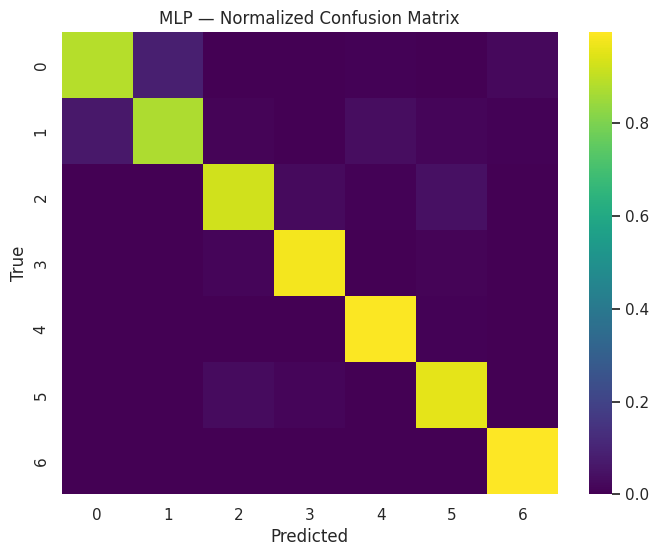

In [13]:
# CELL 7 — Evaluate on test set and report (convert labels back to 1..7)
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# load best weights (optional)
model.load_weights("mlp_best_full.h5")

y_pred_proba = model.predict(X_test, batch_size=1024, verbose=0)
y_pred_zero = np.argmax(y_pred_proba, axis=1).astype(int)

# convert to original label space 1..7
y_test_orig = y_test + 1
y_pred_orig = y_pred_zero + 1

acc = accuracy_score(y_test_orig, y_pred_orig)
f1_macro = f1_score(y_test_orig, y_pred_orig, average='macro')

print("TEST Accuracy :", round(acc,4))
print("TEST Macro-F1:", round(f1_macro,4))
print("\nClassification Report (labels 1..7):\n")
print(classification_report(y_test_orig, y_pred_orig, digits=4))

# Normalized confusion matrix
cm = confusion_matrix(y_test_orig, y_pred_orig)
plt.figure(figsize=(8,6))
sns.heatmap(cm / cm.sum(axis=1, keepdims=True), cmap='viridis')
plt.title("MLP — Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
